# Collecting and Demodulating FM Radio Stations and Using NeMo for Speech to Text Transcription
The following demonstration shows how to:
1. Use [simplesoapy](https://github.com/xmikos/simplesoapy) to capture I/Q signals from an [rtlsdr](https://www.rtl-sdr.com/about-rtl-sdr/)
2. Move I/Q samples collected with the radio to the GPU for processing
3. Use cuSignal to visualize the power spectrum of the signal on the GPU
4. Use cuSignal and CuPy to demodulate the FM radio station and generate a .wav output
5. Use NVIDIA's [NeMo](https://github.com/NVIDIA/NeMo) ASR toolkit to generate a speech-to-text transcription of the recorded .wav with a pre-trained QuartzNet and Citrinet model
6. Use NeMo's Machine Translation models to translate transcipt from English to French

This tutorial is focused on offline processing where we use the rtlsdr to fill a large buffer with I/Q samples (e.g. 15 seconds of recorded data). We then run all downstream processing on this single signal. Other notebooks will demonstrate online signal processing, where we're demodulating smaller buffers, in real time, and running speech to text transcription in real time. This tutorial is primarily meant to familarize developers with the signal processing and software defined radio workflows and tools.

## [First-Run Only] Environment Setup
The below cell installs pyrtlsdr, the Nemo ASR toolkit, QuartzNet model, and required dependencies. You only need to run this once.

In [ ]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

## Install simplesoapy
!pip install simplesoapy

## Import Dependencies

In [1]:
# CPU Powered Libraries
import numpy as np
from scipy import signal

# GPU Powered Libraries
import cupy as cp
import cusignal

# RTL-SDR Support
import simplesoapy

# Plotting
import matplotlib.pyplot as plt

# Nemo Speech to Text
import nemo
import nemo.collections.asr as nemo_asr

# Wav Tools
from scipy.io import wavfile
import IPython

[NeMo W 2021-12-08 11:45:33 optimizers:50] Apex was not found. Using the lamb or fused_adam optimizer will error out.


## Setup SDR to Capture Over the Air Data

In [2]:
sdr = simplesoapy.SoapyDevice('driver=rtlsdr')
sdr.sample_rate = 2.56e6 # Radio sample rate (Hz)
sdr.freq = 88.5e6 # Center frequency (Hz)
sdr.gain = 40

buffer_size = sdr.sample_rate # Use 1 second of data as the buffer size

Found Rafael Micro R820T tuner
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


## Reading Data from RTL-SDR

#### Read 15 seconds of signal data tuned to 88.5MHz [WAMU-DC](https://wamu.org/)

In [3]:
len_collect = 15 #seconds

# Create shared CPU/GPU output buffer
smem_signal = cusignal.get_shared_mem(int(len_collect * sdr.sample_rate), dtype=np.complex64)

# Start radio
sdr.start_stream()

# Read samples from radio and place in output buffer
sdr.read_stream_into_buffer(smem_signal)

# Switch Context to GPU
gpu_signal = cp.asarray(smem_signal)

[INFO] Using format CF32.
Allocating 15 zero-copy buffers


## Plot Periodogram to Visualize Spectrum

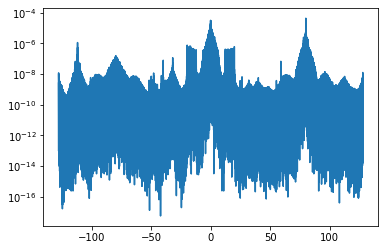

In [4]:
f, Pxx_den = cusignal.periodogram(gpu_signal, sdr.sample_rate, window='hamm', scaling='spectrum', return_onesided=False)
plt.semilogy(cp.asnumpy(cp.fft.fftshift(f/1e4)), cp.asnumpy(cp.fft.fftshift(Pxx_den)))
plt.show()

## FM Demodulate Radio Signal
Without demodulation, your favorite radio station sounds something like this:

In [ ]:
gaudio = cusignal.resample_poly(gpu_signal, 1, sdr.sample_rate//48000, window='hamm')
wavfile.write('sig.wav', rate=48000, data=abs(cp.asnumpy(gaudio)).astype(cp.float32))
IPython.display.Audio('sig.wav')

With demodulation, we can 'decode' the radio collection to hear music, speech, etc

In [ ]:
gdemod_sig = cusignal.fm_demod(gpu_signal)

# Reduce sample rate from radio fs to wav fs
gaudio = cusignal.resample_poly(gdemod_sig, 1, sdr.sample_rate//48000, window='hamm')
wavfile.write('demod_sig.wav', rate=48000, data=cp.asnumpy(gaudio).astype(cp.float32))
IPython.display.Audio('demod_sig.wav')

In [7]:
# Close connection to SDR and Clean Up
sdr.stop_stream()

## Nemo ASR - Obtain Transcript of Recording
Use pre-trained QuartzNet and Citrinet models to run AI inferencing on demodulated radio collection to obtain an English transcription. Citrinet is a significnatly larger model than QuartzNet and tends to have better accuracy. With NeMo, one can see the ease of substituting different pre-trained language models!

### Quartznet

In [ ]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

In [9]:
transcription = quartznet.transcribe(["demod_sig.wav"])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

**Quartznet Transcription Output**

In [10]:
print(transcription[0])

community closed as one as opened as one we didn't have the same in britain um we haven't quite come together as a community in that way so i'm very much in


### Citrinet

In [ ]:
citrinet = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_citrinet_1024")

In [12]:
transcription = citrinet.transcribe(["demod_sig.wav"])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

**Transcription Output**

In [13]:
print(transcription[0])

community closed as one as opened as one we didn't have the same in britain um we haven't quite come together as a community in that way so i'm very much in


## Nemo - Machine Translation - Translate Transcription from English to French

In [ ]:
from nemo.collections.nlp.models import MTEncDecModel

# English to French
model = MTEncDecModel.from_pretrained("nmt_en_fr_transformer12x2")

In [17]:
translations = model.translate([transcription], source_lang="en", target_lang="fr")

**Translation Output**

In [18]:
print(translations[0])

["communauté fermée comme une aussi ouverte que celle que nous n'avions pas la même en Grande-Bretagne euh nous n'avons pas tout à fait réuni comme une communauté de cette façon donc je suis très dedans"]
